In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline

In [70]:
occ_by_ind = pd.read_excel("../data/OES/natsector_M2021_dl.xlsx")

In [71]:
# A lot of total employment and wage estimates for "major" are showing up as unavailable. At some point we need 
# to estimate them from more granular occupation data
occ_by_ind = occ_by_ind[occ_by_ind['O_GROUP'] == 'major'][['NAICS', 'NAICS_TITLE', "OCC_CODE", "OCC_TITLE", "TOT_EMP"]]
occ_by_ind.loc[:, 'TOT_EMP'] = pd.to_numeric(occ_by_ind['TOT_EMP'], errors='coerce').fillna(0)
occ_by_ind.loc[:, 'EMP_PCT'] = occ_by_ind['TOT_EMP']/occ_by_ind.groupby('OCC_CODE')['TOT_EMP'].transform(sum)
pivot_df = occ_by_ind.pivot_table(columns=['OCC_TITLE'], index=['NAICS_TITLE'], values='EMP_PCT').fillna(0)

In [72]:
index_dict = {'Food S':'Accommodation and Food Services', 'Rec':'Arts, Entertainment, and Recreation', 
                'Const':'Construction', 'Educ S':'Educational Services', 'Fin':'Finance and Insurance', 
                'Gov':'Federal, State, and Local Government, excluding state and local schools and hospitals and the U.S. Postal Service (OES Designation)', 
                'Health':'Health Care and Social Assistance',
                'Info': 'Information', 'Mining':'Mining, Quarrying, and Oil and Gas Extraction', 
                'Manu': 'Manufacturing', 'Other S':'Other Services (except Public Administration)', 
                'Bus S': 'Professional, Scientific, and Technical Services', 
                'Real Est':'Real Estate and Rental and Leasing', 'Retail':'Retail Trade', 'Trans':'Transportation and Warehousing',
                'Whsale':'Wholesale Trade', 'Management':'Management of Companies and Enterprises',
                'Admin': 'Administrative and Support and Waste Management and Remediation Services', 
                'Agri': 'Agriculture, Forestry, Fishing and Hunting'}
occ_map = {'Architecture and Engineering Occupations': 'Eng', 
           'Arts, Design, Entertainment, Sports, and Media Occupations': 'Arts',
           'Building and Grounds Cleaning and Maintenance Occupations': 'Clean',
           'Business and Financial Operations Occupations': 'Bus Ops',
           'Community and Social Service Occupations': 'Soc S',
           'Computer and Mathematical Occupations': 'Math',
           'Construction and Extraction Occupations': 'Cons',
           'Educational Instruction and Library Occupations': 'Educ',
           'Farming, Fishing, and Forestry Occupations': 'Agg',
           'Food Preparation and Serving Related Occupations': 'Food S',
           'Healthcare Practitioners and Technical Occupations': 'Health P',
           'Healthcare Support Occupations': 'Health S', 
           'Installation, Maintenance, and Repair Occupations': 'Repair', 
           'Legal Occupations': 'Legal', 'Life, Physical, and Social Science Occupations':'Science',
           'Management Occupations': 'Manag', 'Office and Administrative Support Occupations': 'Admin',
           'Personal Care and Service Occupations': 'Care', 'Production Occupations': 'Prod',
           'Protective Service Occupations': 'Prot S', 'Sales and Related Occupations': 'Sales', 
           'Transportation and Material Moving Occupations': 'Trans'}
index_dict_swap = {v: k for k, v in index_dict.items()}
pivot_df = pivot_df.rename(index=index_dict_swap, columns=occ_map)

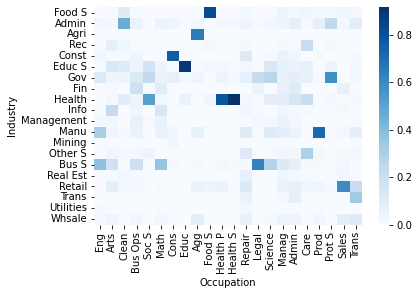

In [73]:
sns.heatmap(pivot_df, cmap="Blues")
plt.xlabel('Occupation')
plt.ylabel('Industry')
plt.savefig('../output/figures/occupation_heatmap.png',dpi=300)

In [74]:
data_dir = '../data/clean/'
dfA      = pd.read_csv(data_dir + 'A.csv')
dfA.columns
dfA.index = dfA.BEA_sector
dfA = dfA.drop(labels=['BEA_sector'],axis=1)


In [75]:
sectors_dict = {'Food S':'Accommodation and food services','Rec':'Arts, entertainment, and recreation',
                'Const':'Construction','Dur':'Durable goods','Educ S':'Educational services','Fin':'Finance and insurance',
                'Gov':'Government','Health S':'Health care and social assistance','Info':'Information','Mining':'Mining',
                'Nondur':'Nondurable goods','Other S':'Other services, except government', 'Bus S':'Professional and business services',
                'Real Est':'Real estate and rental and leasing','Retail':'Retail trade','Trans':'Transportation and warehousing',
                'Whsale':'Wholesale trade'}
sector_dict_swap = {v: k for k, v in sectors_dict.items()}
dfA = dfA.rename(index=sector_dict_swap, columns=sector_dict_swap)


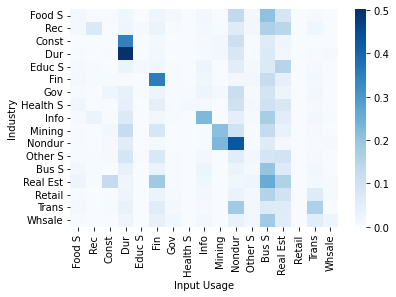

In [76]:
sns.heatmap(dfA, cmap="Blues")
plt.xlabel('Input Usage')
plt.ylabel('Industry')
plt.savefig('../output/figures/sectors_heatmap.png',dpi=300)